# Segment Surgery and Models

In [1]:
%load_ext autoreload
%autoreload 2

# System imports
import os
import sys
import yaml

# External imports
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.metrics import auc
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
import scipy.sparse.csgraph as scigraph
import scipy.sparse as sp


import wandb

import warnings
warnings.filterwarnings('ignore')
sys.path.append('../../../')
device = "cuda" if torch.cuda.is_available() else "cpu"

## Roadmap

1. Load in a good 0.5GeV model
2. Run some initial statistics (eff, pur)
3. Segment builder
4. Get some segment statistics (tracking eff, pur)

## Infrastructure

- GraphScore(Model, graph) --> graph (with scores)
- SegmentBuild(graph) --> labelled graph


## Load in Model

In [2]:
from LightningModules.GNN.Models.interaction_gnn import InteractionGNN
from LightningModules.GNN.Models.checkpoint_pyramid import CheckpointedPyramid

In [3]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_Barrel_GNN/11eo3iqk/checkpoints/epoch=21-step=10449.ckpt"
checkpoint = torch.load(checkpoint_path)

model = InteractionGNN.load_from_checkpoint(checkpoint_path).to(device)

### Load in Data

In [4]:
model._hparams["datatype_split"]=[50, 50, 10]

In [5]:
model.setup(stage="fit")

Setting up dataset
Loading events
Events loaded!
Events processed!
Loading events
Events loaded!
Events processed!
Loading events
Events loaded!
Events processed!


## Load/Score Graphs

### Load Pre-scored

In [17]:
graph_dir = "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0.5GeV_barrel_y"
all_files = [os.path.join(segment_dir, file) for file in os.listdir(graph_dir)] 

In [33]:
all_files

['/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0.5GeV_barrel_y/0200.npz',
 '/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0.5GeV_barrel_y/0178.npz',
 '/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0.5GeV_barrel_y/0069.npz',
 '/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0.5GeV_barrel_y/0101.npz',
 '/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0.5GeV_barrel_y/0188.npz',
 '/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0.5GeV_barrel_y/0079.npz',
 '/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0.5GeV_barrel_y/0111.npz',
 '/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0.5GeV_barrel_y/0002.npz',
 '/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0.5GeV_barrel_y/0089.npz',
 '/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_processed/0.5GeV_barrel_y/0121.npz',
 '/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/gnn_pro

In [18]:
graph = np.load(all_files[0])

In [23]:
edge_list = np.stack([graph["senders"], graph["receivers"]])

### Score

In [6]:
def graphScore(model, events=None, output_dir=None):
    if events is None:
        events = model.valset
    
    # TODO: Run model over graphs and attach scores
    # If output_dir, then save to output_dir, else return events
    with torch.no_grad():
        for event in model.valset:
            batch = event.to(device)
            
            input_data = model.get_input_data(batch)
            input_edges = torch.cat([batch.edge_index, batch.edge_index.flip(0)], dim=-1)
            scores = torch.sigmoid(model(input_data, input_edges))[:event.edge_index.shape[1]]
            
            event.scores = scores

In [7]:
%%time
graphScore(model)

CPU times: user 18.8 s, sys: 8.95 ms, total: 18.9 s
Wall time: 18.8 s


## Load/Build Segments

In [8]:
def labelGraph(graph, edge_cut=0.5):
    
    # apply cut
    passing_edges = graph.edge_index[:, graph.scores > edge_cut]
    
    # attach labels to data
    graph.labels = labelSegments(passing_edges, graph)

def labelSegments(input_edges, graph):
    
    # get connected components
    sparse_edges = sp.coo_matrix((np.ones(input_edges.shape[1]), input_edges.cpu().numpy()), shape=( len(graph.x), len(graph.x)))
    connected_components = scigraph.connected_components(sparse_edges)[1]
    
    return torch.from_numpy(connected_components).type_as(input_edges)

In [9]:
graph = model.valset[0]

In [10]:
cut = 0.8

positive = graph.scores > cut
tp = positive & graph.y.bool()
labelGraph(graph, edge_cut=cut)
print("Pur:", tp.sum() / positive.sum(), "Eff:", tp.sum() / graph.y.sum())

Pur: tensor(0.4074, device='cuda:0') Eff: tensor(0.7958, device='cuda:0')


## Diagnosis

### 0. Plot Everything

In a SMALL slice
1. Plot all hits
2. Plot all signal hits
4. Plot all true/false positive edges
3. Plot all false negative signal edges
5. Plot a BIG component

In [271]:
r, phi, z = graph.x.T.cpu()
x, y = r*np.cos(np.pi * phi), r*np.sin(np.pi*phi)

In [150]:
background_hits = ~np.isin(np.arange(len(graph.x)), graph.signal_true_edges)
signal_hits = np.isin(np.arange(len(graph.x)), graph.signal_true_edges)

In [158]:
phi_min, phi_max = -0.2, 0.2
hit_phi_cut = phi_min < phi < phi_max
# edge_phi_cut = (phi_min < phi[graph] < phi_max) & (phi_min < phi < phi_max)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [162]:
(phi_min < phi) & (phi < phi_max)

tensor([True, True, True,  ..., True, True, True])

In [149]:
signal_hits.shape

(104365,)

In [297]:
def cut_edges(edge_list, value, val_min, val_max):
    
    included_edges = edge_list[:, (val_min < value[edge_list[0]]) & (value[edge_list[0]] < val_max) & (val_min < value[edge_list[1]]) & (value[edge_list[1]] < val_max)]
    
    return included_edges

In [298]:
def plot_segments(graph, phi_min, phi_max, cut=0.5):
    
    r, phi, z = graph.x.T.cpu().numpy()
    x, y = r*np.cos(np.pi * phi), r*np.sin(np.pi*phi)
    
    background_hits = ~np.isin(np.arange(len(graph.x)), graph.signal_true_edges)
    signal_hits = np.isin(np.arange(len(graph.x)), graph.signal_true_edges)
    
    positive_edges = graph.scores > cut
    true_positive_signal_edges = graph.edge_index[:, positive_edges & graph.y.bool()]
    false_positive_edges = graph.edge_index[:, positive_edges & ~graph.y.bool()]
#     false_negative_signal_edges = np.isin(graph.signal_true_edges, true_positive_signal_edges)
    
    # Apply phi cut
    background_hits, signal_hits = background_hits & (phi_min < phi) & (phi < phi_max), signal_hits & (phi_min < phi) & (phi < phi_max)
    
    true_positive_signal_edges = cut_edges(true_positive_signal_edges, phi, phi_min, phi_max)
    false_positive_edges = cut_edges(false_positive_edges, phi, phi_min, phi_max)
    all_true_signal_edges = cut_edges(graph.signal_true_edges, phi, phi_min, phi_max)
    
#     fig = plt.figure(figsize=(20,10))
#     make_scatter_plots(r, phi, background_hits, signal_hits)
#     make_line_plots(r, phi, all_true_signal_edges, false_positive_edges, true_positive_signal_edges)
    
    fig = plt.figure(figsize=(20,20))
    make_scatter_plots(x, y, background_hits, signal_hits)
    make_line_plots(x, y, all_true_signal_edges, false_positive_edges, true_positive_signal_edges)
    
def make_scatter_plots(coord1, coord2, background_hits, signal_hits):
    plt.scatter(coord1[background_hits], coord2[background_hits], c="k", s=1)
    plt.scatter(coord1[signal_hits], coord2[signal_hits], c="b", s=50, marker="x")
    

def make_line_plots(coord1, coord2, all_true_signal_edges, false_positive_edges, true_positive_signal_edges):
    
    plt.plot(coord1[false_positive_edges], coord2[false_positive_edges], c="red", alpha=0.2)
    plt.plot(coord1[all_true_signal_edges], coord2[all_true_signal_edges], c="indigo")
    plt.plot(coord1[true_positive_signal_edges], coord2[true_positive_signal_edges], c="turquoise", linewidth=1)
    
    

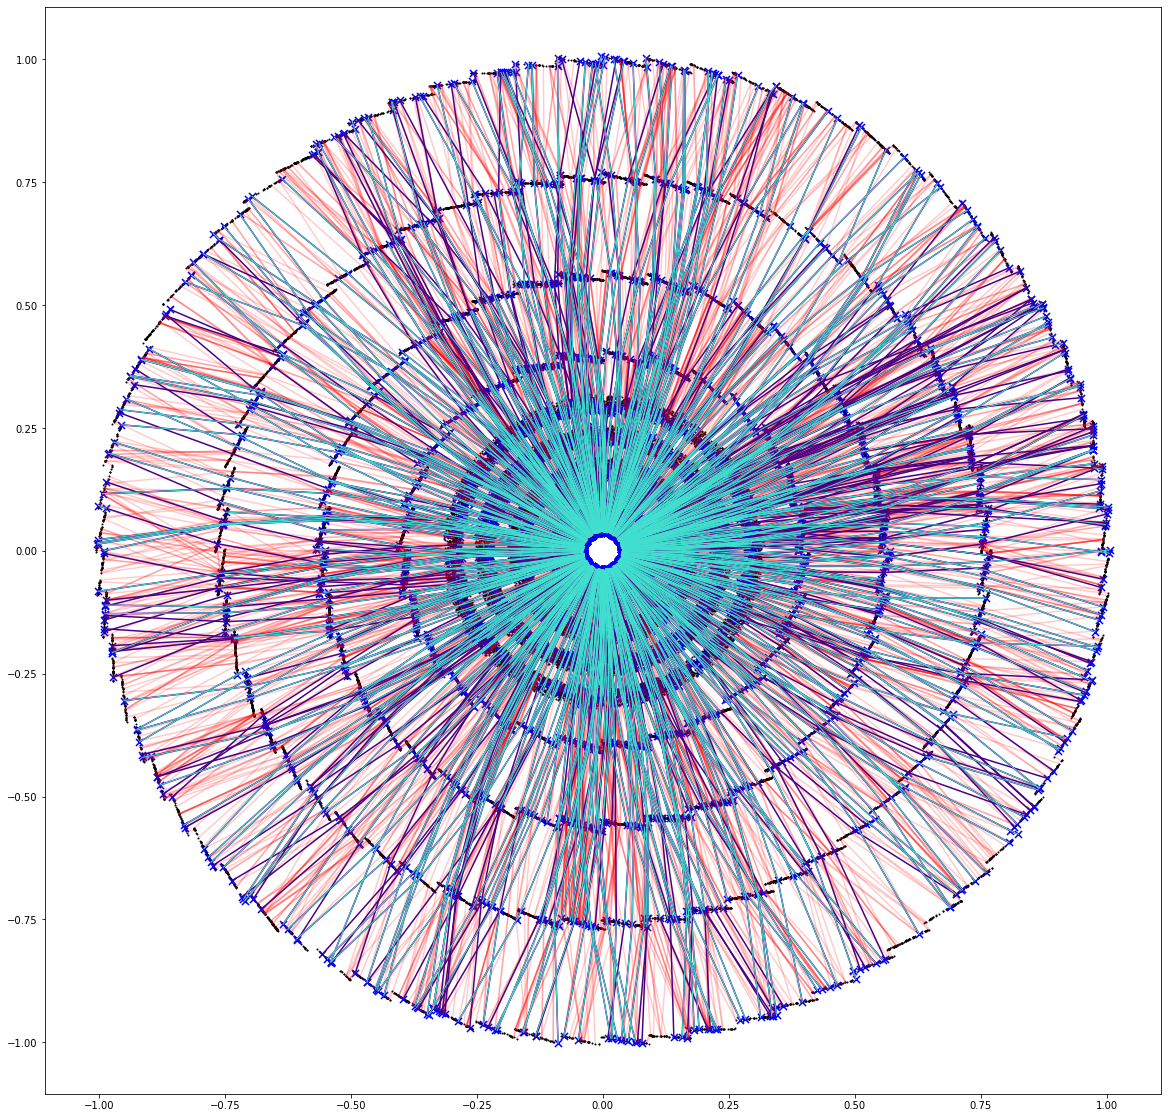

In [299]:
plot_segments(graph, -1, 1, 0.6)

### Big Segment

In [277]:
big_seg = connected_components == 260

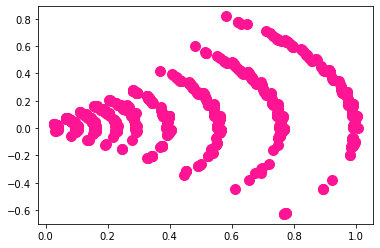

In [278]:
plt.scatter(x[big_seg], y[big_seg], c="deeppink", s=100)

In [279]:
big_seg = connected_components == 5197

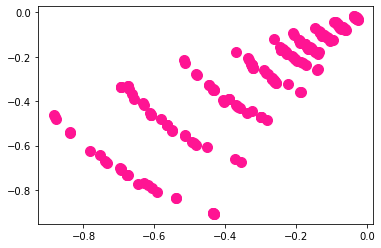

In [280]:
plt.scatter(x[big_seg], y[big_seg], c="deeppink", s=100)

### 1. ~Perfect Segments

A segment that contains >80% of a track and >80% of that segment is that single track

In [118]:
connected_components

array([  0,   1,   2, ..., 428, 428, 428], dtype=int32)

1. Start with all components with > 1 hit
2. Visualise component lengths
3. For each component, if >80% of hits have same PID, get that PID - else continue
4. If >80% of that PID's hits are in component, ..., else continue
5. 

In [290]:
segment_ids, segment_lengths = np.unique(connected_components, return_counts=True)

In [291]:
segment_lengths[segment_lengths > 1].shape

(3157,)

<AxesSubplot:ylabel='Count'>

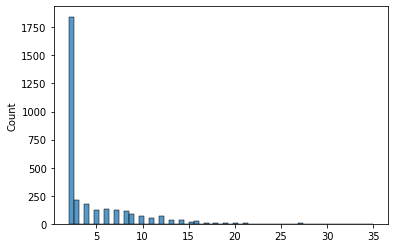

In [294]:
sns.histplot(segment_lengths[segment_lengths > 1])

### Summary Statistics

In [331]:
print("There are", len(segment_ids[segment_lengths > 2]), "segments with length >= 3")

There are 1312 segments with length >= 3


In [353]:
print("There are", len(segment_ids[segment_lengths > 5]), "segments with length >= 5")

There are 805 segments with length >= 5


In [348]:
signal_pids = graph.pid[graph.signal_true_edges.unique()].unique()

In [341]:
print("There are", len(graph.pid[graph.signal_true_edges.unique()].unique()), "signal particles with length >= 3")

There are 846 signal particles with length >= 3


### Perfect Segments

In [370]:
perfect_segments = []

for sid in segment_ids[segment_lengths > 1]:
    
    # Get PIDs in that segment
    segment = connected_components == sid
    
    pid_list = graph.pid[segment]
    unique_pids, pid_counts = pid_list.unique(return_counts = True)
    
    dominant_pid = unique_pids[pid_counts.argmax()]
    dominant_count = pid_counts.max()
    
    if dominant_count >= (len(pid_list) * 0.8):
                
        # Get PID true count
        true_track_length = (graph.pid == dominant_pid).sum()
                
        if dominant_count >= (true_track_length * 0.8):
            if np.isin(dominant_pid, signal_pids):
                perfect_segments.append(segment)

In [371]:
len(perfect_segments)

278

### Matching Segments

In [349]:
matching_segments = []

for sid in segment_ids[segment_lengths > 1]:
    
    # Get PIDs in that segment
    segment = connected_components == sid
    
    pid_list = graph.pid[segment]
    unique_pids, pid_counts = pid_list.unique(return_counts = True)
    
    dominant_pid = unique_pids[pid_counts.argmax()]
    dominant_count = pid_counts.max()
    
    if dominant_count > (len(pid_list) * 0.5):
                
        # Get PID true count
        true_track_length = (graph.pid == dominant_pid).sum()
                
        if dominant_count > (true_track_length * 0.5):
            if np.isin(dominant_pid, signal_pids):
                matching_segments.append(segment)

In [350]:
np.isin(dominant_pid, signal_pids)

array(False)

In [351]:
len(matching_segments)

614

### Broken Segments

In [373]:
broken_segments = []

for pid in signal_pids:
    
    segments = connected_components[graph.pid == pid]
    
    unique_sids, sid_counts = np.unique(segments, return_counts = True)
    
    dominant_sid = unique_sids[sid_counts.argmax()]
    dominant_count = sid_counts.max()
    
    if dominant_count < (len(segments) * 0.5):
        
        broken_segments.append(segments)        

In [374]:
len(broken_segments)

117

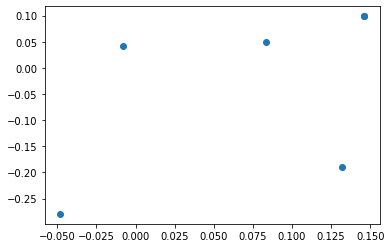

In [375]:
plt.scatter(x[broken_segments[10]], y[broken_segments[10]])

In [383]:
graph.pid[connected_components == 748]

tensor([60320000553, 60320000553, 60320000553, 60320000553, 60320000553,
        60320000553, 60320000553,           0, 60320000553, 60290200004,
        60320000553, 60320000553,           0,           0,           0,
               1504,        1504,           0])

In [377]:
broken_segments[0]

array([  976,   989, 10089, 10089, 10089, 10089, 80800,   748,   748],
      dtype=int32)

In [369]:
graph.pid[matched_merged_segments[0]]

tensor([60620000234,        1766, 60620000234,        1766, 60620000234,
        60620000234,        1766,        1766, 60620000234,        1766,
               1766, 60620000234, 60620000234,           0,           0,
                  0,           0,           0, 60140000426])

### Merged Segments

In [361]:
matched_merged_segments = []

for sid in segment_ids[segment_lengths > 1]:
    
    # Get PIDs in that segment
    segment = connected_components == sid
    
    pid_list = graph.pid[segment]
    unique_pids, pid_counts = pid_list.unique(return_counts = True)
    
    dominant_pid = unique_pids[pid_counts.argmax()]
    dominant_count = pid_counts.max()
    
    if dominant_count < (len(pid_list) * 0.5):
                
        # Get PID true count
        true_track_length = (graph.pid == dominant_pid).sum()
                
        if dominant_count >= (true_track_length * 0.5):
            matched_merged_segments.append(segment)

In [362]:
len(matched_merged_segments)

46

In [363]:
unmatched_merged_segments = []

for sid in segment_ids[segment_lengths > 1]:
    
    # Get PIDs in that segment
    segment = connected_components == sid
    
    pid_list = graph.pid[segment]
    unique_pids, pid_counts = pid_list.unique(return_counts = True)
    
    dominant_pid = unique_pids[pid_counts.argmax()]
    dominant_count = pid_counts.max()
    
    if dominant_count < (len(pid_list) * 0.5):
                
        # Get PID true count
        true_track_length = (graph.pid == dominant_pid).sum()
                
        if dominant_count < (true_track_length * 0.5):
            unmatched_merged_segments.append(segment)

In [364]:
len(unmatched_merged_segments)

74

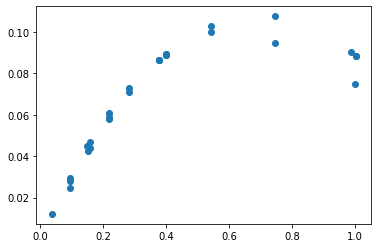

In [367]:
plt.scatter(x[matched_merged_segments[10]], y[matched_merged_segments[10]])

In [369]:
graph.pid[matched_merged_segments[0]]

tensor([60620000234,        1766, 60620000234,        1766, 60620000234,
        60620000234,        1766,        1766, 60620000234,        1766,
               1766, 60620000234, 60620000234,           0,           0,
                  0,           0,           0, 60140000426])

In [358]:
(graph.pid == 60620000234).sum()

tensor(8)

## Input Graph

Examine the truth graph first:

In [11]:
# attach labels to data
labels = labelSegments(graph.signal_true_edges, graph)

In [14]:
(labels.unique(return_counts=True)[1] >= 2).sum()

tensor(847, device='cuda:0')

In [15]:
labels

tensor([    0,     1,     2,  ..., 98475, 98476, 98477], device='cuda:0')

In [60]:
graph.

torch.Size([6734])

In [15]:
all_signal_particles = graph.pid[graph.signal_true_edges].unique()

In [16]:
def score_segments(labels, pids, unique_signal_pids):

    total_score = 0

    # For each signal particle P
    
    for P in unique_signal_pids:

        relevant_segments = labels[pids == P].unique()

        # For each segment that contains a particle hit S

        total_iou = 0

        for S in relevant_segments:

            # Sum intersecting hits between P & S
            i = ((pids == P) & (labels == S)).sum()

            # Sum union of P & S hits
            u = ((pids == P) | (labels == S)).sum()

            # Get square of i/u
            total_iou += (i/u)**2

        # Take sqrt of all segments

        total_score += torch.sqrt(total_iou)

    # Take mean of all particles
    mean_score = total_score / len(unique_signal_pids)
    
    return mean_score

In [21]:
%%time
mean_score = score_segments(labels, graph.pid, all_signal_particles)

CPU times: user 330 ms, sys: 3.27 ms, total: 333 ms
Wall time: 332 ms


In [22]:
mean_score

tensor(0.9994, device='cuda:0')

Let's see what score the input graph could get from ground truth

In [15]:
labels = labelSegments(graph.edge_index[:, graph.y.bool()], graph)

In [143]:
%%time
mean_score = score_segments(labels, graph.pid, all_signal_particles)

CPU times: user 456 ms, sys: 0 ns, total: 456 ms
Wall time: 454 ms


In [144]:
mean_score

tensor(0.9420, device='cuda:0')

In [152]:
(labels.unique(return_counts=True)[1] >= 2).sum()

tensor(951, device='cuda:0')

Now let's see what the actual score would be

In [140]:
%%time
mean_score = score_segments(graph.labels, graph.pid, all_signal_particles)

CPU times: user 649 ms, sys: 0 ns, total: 649 ms
Wall time: 648 ms


In [141]:
mean_score

tensor(0.6744, device='cuda:0')

In [153]:
(graph.labels.unique(return_counts=True)[1] >= 2).sum()

tensor(3156, device='cuda:0')

### Sparse Approach

In [30]:
def sparse_score_segments(labels, pids, signal_pids):
    
    unique_pids, new_pids = pids.unique(return_inverse=True)
    signal_segments_pids, unique_signal_segments_pids = get_unique_signal_segments(labels, new_pids, signal_pids)
    
    
    iou, segment_count, pid_count = get_jaccard_matrix(labels, new_pids, signal_segments_pids, unique_signal_segments_pids)
    
    sparse_segment_count = sp.coo_matrix((segment_count[unique_signal_segments_pids[0]].cpu(), unique_signal_segments_pids.cpu().numpy())).tocsr()
    sparse_pid_count = sp.coo_matrix((pid_count[unique_signal_segments_pids[1]].cpu(), unique_signal_segments_pids.cpu().numpy())).tocsr()
    
    segment_pur = iou.multiply(sparse_segment_count).sum() / segment_count[unique_signal_segments_pids[0]].sum()
    segment_eff = iou.multiply(sparse_pid_count).sum() / pid_count[unique_signal_segments_pids[1]].sum()
    
    segment_f1 = 2 * segment_pur * segment_eff / (segment_pur + segment_eff)
    
    return segment_pur, segment_eff, segment_f1

def get_jaccard_matrix(labels, pids, signal_segments_pids, unique_signal_segments_pids):
    
    sparse_intersection = sp.coo_matrix((np.ones(signal_segments_pids.shape[1]), signal_segments_pids.cpu().numpy())).tocsr()
    
    segment_count = labels.unique(return_counts=True)[1]
    pid_count = pids.unique(return_counts=True)[1]
    
    union_counts = segment_count[unique_signal_segments_pids[0]] + pid_count[unique_signal_segments_pids[1]]
    sparse_sum = sp.coo_matrix((union_counts.cpu(), unique_signal_segments_pids.cpu().numpy())).tocsr()
    sparse_union = sparse_sum - sparse_intersection
    sparse_union.data = 1 / sparse_union.data
    iou = sparse_intersection.multiply(sparse_union)
    
    return iou, segment_count, pid_count

def get_unique_signal_segments(labels, pids, signal_pids):
    
    labels_unique, labels_inverse, labels_counts = labels.unique(return_counts=True, return_inverse=True)
    
    segments_pids = torch.stack([labels, pids])
    is_signal = torch.isin(pids, pids[signal_pids]) & (labels_counts[labels_inverse] >= 3)
    
    signal_segments_pids = segments_pids[:, is_signal]
    unique_signal_segments_pids = signal_segments_pids.unique(dim=1)
    
    return signal_segments_pids, unique_signal_segments_pids

In [35]:
sparse_score_segments(graph.labels, graph.pid, graph.signal_true_edges)

(tensor(0.5578, device='cuda:0'),
 tensor(0.5798, device='cuda:0'),
 tensor(0.5686, device='cuda:0'))